<a href="https://colab.research.google.com/github/mahaley22/Uncertainty-Scoring/blob/master/Machine_Translation_with_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####   **Using Uncertainty Scoring for a Seq2seq MT model**  
2020 Mike Haley.




(Adapted from: <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Neural machine translation with attention</a>)

This notebook trains a sequence to sequence (seq2seq) model for machine translation, using Attention. However, instead of looking at the Attention plots, we will be looking at a whole lot of Uncertainty plots and aggregating by uncertainty to reveal some directions for analyzing avoidable bias, variance, and sampling for Active Learning.  

This work was inspired in part by *Human-in-the-Loop Machine Learning* by Robert Munro © 2020  The reader of this notebook can skip down to the sections where the bulk of my work begins [Translate (with Uncertainty!)](#Translate).

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?   Attribution: tatoeba.org #2245231 (CK) & #6077611 (fekundulo)
```


To import the training and validation data, (which we want to have even if we've already saved off a model), you'll have to run something like the following two cells.   If you want to just go with the spanish language as was originally used in the original notebook (referenced at the top of this notebook) there may be no need to download the file into a google drive folder somewhere.  I've had trouble doing so outside of the original notebook, but leave the option in the code below.  I happened change the original source input language from Spanish to Hebrew as a first go, but you might want to replace that below.


In [ ]:
source_lang='heb'

In [ ]:
if source_lang!='spa':
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the file
def get_path_to_file(lang='spa'):
  if lang=='spa':  
    path_to_zip = tf.compat.v2.keras.utils.get_file(
      'spa-eng.zip', origin='https://drive.google.com/file/d/1X5vqyh0bVii_VLcC9uEY7JzruFlMnBCS/view?usp=sharing',
      extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file
  else: #your own google drive
    import zipfile
    my_colab_folder = "/content/drive/My Drive/Colab Notebooks"
    with zipfile.ZipFile(my_colab_folder + "/"+source_lang+"-eng.zip", 'r') as zip_ref:
      zip_ref.extractall(my_colab_folder)
    path_to_file = my_colab_folder+"/"+source_lang+".txt"
    return path_to_file

In [ ]:
path_to_file = get_path_to_file(source_lang)
path_to_file

'/content/drive/My Drive/Colab Notebooks/heb.txt'

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, lang):
  w = w.lower().strip() 
  if source_lang=="spa":
    unicode_to_ascii(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") - this is source langauge-specific! hence the conditional placeholder
  if source_lang=="spa": 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
english_sentence = u"We ate.	"
source_sentence = u"אכלנו."
print(preprocess_sentence(english_sentence, source_lang))
source_sentence = preprocess_sentence(source_sentence, source_lang)
if source_lang=="spa": #use for other languages as well
  source_sentence.encode('utf-8')
print(source_sentence)

<start> we ate . <end>
<start> אכלנו . <end>


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SOURCE]
def create_dataset(path, num_examples):
  lines = io.open(path).read().strip().split('\n')#io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(len(lines))
  print(lines[-30000])
  word_pairs = [[preprocess_sentence(w, source_lang) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  #print(word_pairs[-1])

  return zip(*word_pairs)

In [ ]:
english, source = create_dataset(path_to_file, 30000)
print(english[0])
print(source[0])

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
<start> hi . <end>
<start> היי . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  #print(inp_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> אני
1635 ----> מניח
45 ----> כך
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
564 ----> guess
79 ----> so
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#print(example_target_batch[0:])

(TensorShape([64, 11]), TensorShape([64, 10]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5303)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<a id="Training"></a>
## Training

Details of training for this interested from original attention notebook:
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6231
Epoch 1 Batch 100 Loss 2.0841
Epoch 1 Batch 200 Loss 1.8176
Epoch 1 Batch 300 Loss 1.4804
Epoch 1 Loss 1.9347
Time taken for 1 epoch 44.24178385734558 sec

Epoch 2 Batch 0 Loss 1.3901
Epoch 2 Batch 100 Loss 1.4290
Epoch 2 Batch 200 Loss 1.3833
Epoch 2 Batch 300 Loss 1.2350
Epoch 2 Loss 1.3205
Time taken for 1 epoch 32.22664952278137 sec

Epoch 3 Batch 0 Loss 1.0557
Epoch 3 Batch 100 Loss 1.0574
Epoch 3 Batch 200 Loss 0.9757
Epoch 3 Batch 300 Loss 0.9373
Epoch 3 Loss 1.0056
Time taken for 1 epoch 31.139586925506592 sec

Epoch 4 Batch 0 Loss 0.7755
Epoch 4 Batch 100 Loss 0.8403
Epoch 4 Batch 200 Loss 0.7814
Epoch 4 Batch 300 Loss 0.7566
Epoch 4 Loss 0.7416
Time taken for 1 epoch 32.602859020233154 sec

Epoch 5 Batch 0 Loss 0.5371
Epoch 5 Batch 100 Loss 0.5714
Epoch 5 Batch 200 Loss 0.5678
Epoch 5 Batch 300 Loss 0.4211
Epoch 5 Loss 0.5206
Time taken for 1 epoch 31.48190927505493 sec

Epoch 6 Batch 0 Loss 0.2942
Epoch 6 Batch 100 Loss 0.3413
Epoch 6 Batch 200 Lo

In [ ]:
# since this is a custom training loop, cannot use below.  
# (cf. Chapter 6 Deep Learning With Python (2nd edition))
#loss_and_metrics = decoder.evaluate(input_tensor_val, target_tensor_val, batch_size=128)


<a id=’Translate’></a>
##Translate (with Uncertainty!)

Here's where the fun begins.  Instead of keeping the attention weights around in order to plot them, we're going to use the final layer outputs in the following way:
* softmax normalization to yield a "probabilistic" uncertainty score.
* For every timestamp, we also remember the "runner-up" token.  This proves useful as some translations a high "runner-up" score can show us an alternate (acceptable) translation for that token, and also why there may be uncertainty
* We store scores for most confidence, Margin of Confidence between the first and second "score", and a combination (multiplicaton) of the two as our third plot.
* Later on, we will take an average across the entire sequence as an aggregate measure of sequence confidence.



In [ ]:
def get_uncertainty_metrics(uncertainty_scores, t, softmax_output):  
    sorted_scores = tf.sort(softmax_output, direction='DESCENDING')
    predicted_probability_score = sorted_scores[0].numpy()
    
    # 1. Least Confidence 
    #   here I did not bother to add the * (num_labels/(numlabels-1) as numlabels is equal to (large) vocab size)
    least_confidence = (1 - predicted_probability_score) 
    uncertainty_scores[t,0] = least_confidence

    # 2. Margin of Confidence
    margin = sorted_scores[0].numpy() - sorted_scores[1].numpy()   
    margin_of_confidence_score = (1-margin)
    uncertainty_scores[t,1] = margin_of_confidence_score

    # 3 Combined 
    combined_uncertainty_score = (1 - predicted_probability_score*margin)
    uncertainty_scores[t,2] = combined_uncertainty_score

    #print("For token: '" + predicted_word + "', probability score is: " + str(predicted_probability_score) +
    #      ", and Uncertainty Score: " + uncertainty_score + ", and Combined Uncertainty Score: " + str(combined_uncertainty_score)) 
    return uncertainty_scores 

For those interested or as a reference, here are some details from the original attention nb:
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*. - NOT USED HERE

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence, source_lang)
  uncertainty_scores = np.zeros((max_length_targ, 3)) 

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  runner_up_result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on - NOT USED HERE
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    # Here's where we use softmax (post-optimization) on the raw logits 
    softmax_output = tf.nn.softmax(predictions[0])

    uncertainty_scores = get_uncertainty_metrics(uncertainty_scores, t, softmax_output)

    ranking = tf.argsort(softmax_output, direction='DESCENDING')
    predicted_id = ranking[0].numpy() #equivalent to tf.argmax(softmax_output).numpy()
    runner_up_id = ranking[1].numpy()
    predicted_word = targ_lang.index_word[predicted_id]
    runner_up_word = targ_lang.index_word[runner_up_id] 

    result += predicted_word + ' '
    runner_up_result += runner_up_word + ' '

    if predicted_word == '<end>':
      return result, runner_up_result, sentence, uncertainty_scores

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, runner_up_result, sentence, uncertainty_scores

In [ ]:
#Below thresholds are arbitrary and are really for bar chart colors only.  We'll get to optimization later!
high_confidence_threshold = 0.67
medium_confidence_threshold = 0.33

In [ ]:
def label_bar(ax, plots):  
  for bar in plots:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, '{:.2g}'.format(yval), va='bottom') #va: vertical alignment y positional argument

# function for plotting the certainty scores
def plot_uncertainty(scores, titles, predicted_sentence):
  tokens = tuple(predicted_sentence)
  x = np.arange(len(tokens))
  plt.rcParams["figure.figsize"] = [5*1.618,2.5]
  fig, ax = plt.subplots(1, len(scores[1]))
  plt.ylabel = "Uncertainty" #TODO don't know why this doesn't show up in left Y margin
  
  for p in range(len(scores[1])):
    y = scores[:, p]

    mask_red = y > high_confidence_threshold
    mask_yellow = np.logical_and(y >= medium_confidence_threshold, y < high_confidence_threshold)
    mask_green = y < medium_confidence_threshold

    ax[p].set_ylim([0, 1])
    red_plots = ax[p].bar(x[mask_red], y[mask_red], color = 'red')
    label_bar(ax[p], red_plots)
    yellow_plots = ax[p].bar(x[mask_yellow], y[mask_yellow], color = 'yellow')
    label_bar(ax[p], yellow_plots)
    green_plots = ax[p].bar(x[mask_green], y[mask_green], color = 'green')
    label_bar(ax[p], green_plots)

    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].set_title(titles[p])

  #plt.title('Output: {}'.format(predicted_sentence))
  plt.show()

In [ ]:
def translate(sentence, verbose=True):
  result, runner_up, sentence, scores = evaluate(sentence)
  tokenized_result = [t for t in result.split(' ') if t] 
  if verbose:
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Runner-up translation: {}'.format(runner_up))
    titles = ['Least Conf', 'Margin of Conf', 'Combined Conf']
    uncertainty_plot = scores[:len(tokenized_result)]
    plot_uncertainty(uncertainty_plot, titles, tokenized_result)
  else: 
    return scores, tokenized_result

## Restore the latest checkpoint and run a few sample translations
Bear in mind your model depends on the train/val distribution, so results may vary (feel free to input anything here and see what happens!).  Bear in mind that every source has one possible target (we don't have alternate reference translations).  Note in some cases that the **runner-up translation** token can explain some of the uncertainty in some cases.

In [ ]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Target: Can I use this bike?

Input: <start> מותר לי להשתמש באופניים ? <end>
Predicted translation: can i use this bike ? <end> 
Runner-up translation: may you take these ? . tv 


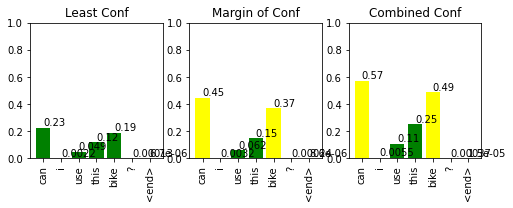

In [ ]:
# here we see the 'may' vs. 'can' uncertainty, depending on the training 
print("Target: Can I use this bike?") 
translate(u'מותר לי להשתמש באופניים?')

Target: Is anything wrong?

Input: <start> משהו לא בסדר ? <end>
Predicted translation: is anything wrong ? <end> 
Runner-up translation: are something okay fault ? 


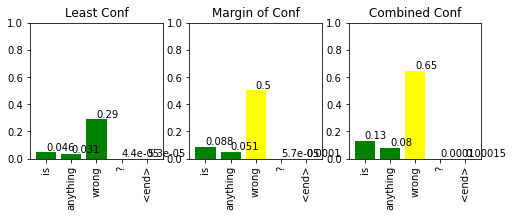

In [ ]:
#"Anything" vs. "something" uncertainty 
print("Target: Is anything wrong?")
translate(u'משהו לא בסדר?')

Target: Is this our flight?

Input: <start> זאת הטיסה שלנו ? <end>
Predicted translation: is this our flight ? <end> 
Runner-up translation: are it is hotel . tv 


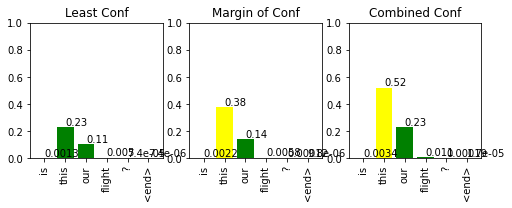

In [ ]:
 # note the "this" versus "that" uncertainty.  In my run it got "Is this our book" but "book" has very high uncertainty
 print("Target: Is this our flight?")
 translate(u'זאת הטיסה שלנו?')

Target: Stop grumbling.

Input: <start> תפסיק להתלונן . <end>
Predicted translation: quit complaining . <end> 
Runner-up translation: stop talk in . 


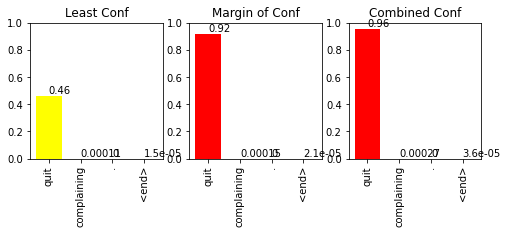

In [ ]:
# "grumbling" vs. "complaining" uncertainty sometimes, "quit" vs. "stop" other times
print("Target: Stop grumbling.")
translate(u'תפסיק להתלונן.')



Target: Do you see it?

Input: <start> אתה רואה את זה ? <end>
Predicted translation: do you see it ? <end> 
Runner-up translation: you it steal that up ? 


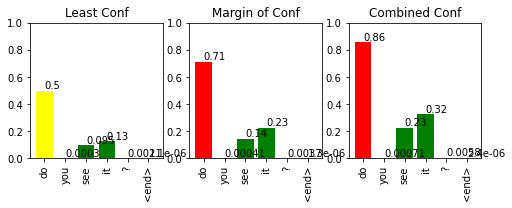

In [ ]:
#"it" versus "that", or "do" vs. <empty>
print("Target: Do you see it?")
translate(u'אתה רואה את זה?')

Target: My cat loves toys.

Input: <start> החתול שלי אוהב צעצועים <end>
Predicted translation: my mom loves catnip . <end> 
Runner-up translation: is idea is cake ? . 


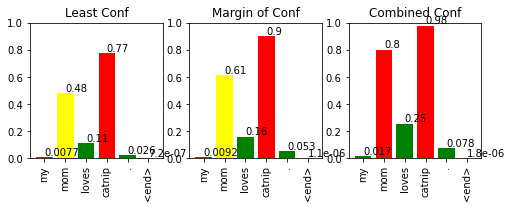

In [ ]:
print("Target: My cat loves toys.")
translate(u'החתול שלי אוהב צעצועים')

In [ ]:
print("Target: If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.")
translate(u'אם מישהו שאינו מכיר את הרקע שלכם אומר שאתם נשמעים כמו דוברים ילידים , פירוש הדבר שהוא מן הסתם הבחין במשהו בדיבורכם שגרם לו להבין שאינכם דוברים ילידים . במילים אחרות , אתם לא באמת נשמעים כמו דוברים ילידים .')


##Towards Uncertainty (and Certainty) Sampling
Now that we've seen some interesting values for individual translation tokens, we're ready to approach some uncertainty sampling using an aggregation across the entire sequence.

Let's just start with the admittedly arbitrary guess-timated thresholds below
and equally sized subsets of both our training and validation sets for testing against these thresholds.  We do want to choose these thresholds in a more sophisticated way, but for now it will do for exploration.

In [ ]:
total_test_size=1000
uncertainty_sampling_treshold = 0.2
certainty_sampling_treshold = 0.02

In [ ]:
#Some table-setting functions we'll need:

def convert_to_sentence(lang, tensor):
  sentence = "";
  for t in tensor:
    if t not in [0, 1, 2]:
      sentence = sentence + ' ' + lang.index_word[t]
  return sentence

def translate_sentences(inp_lang, targ_lang, input_tensor, target_tensor, range, verbose=True):
  scores = []
  results = []
  for s in range:
    input_sentence = convert_to_sentence(inp_lang, input_tensor[s])
    target_sentence = convert_to_sentence(targ_lang, target_tensor[s])
    if verbose:
      print("\n\nSentence: " + input_sentence)
      print("Target: " + target_sentence)
    score, result = translate(input_sentence, verbose)
    scores.append(score)
    results.append(result)
  return np.array(scores), np.array(results)



In [ ]:
def get_high_uncertainty_sample_size(sequence_mean, threshold = uncertainty_sampling_treshold):
  mask_uncertainty = sequence_mean > threshold
  uncertainty_sample = sequence_mean[mask_uncertainty]
  uncertainty_sample_size = len(uncertainty_sample)
  print("Uncertainty set size: " + str(uncertainty_sample_size) + " out of " + str(len(sequence_mean)))
  return uncertainty_sample_size

def get_low_uncertainty_sample_size(sequence_mean, threshold = certainty_sampling_treshold):
  mask_uncertainty = sequence_mean <= threshold
  certainty_sample = sequence_mean[mask_uncertainty]
  certainty_sample_size = len(certainty_sample)
  print("Certainty subset size: " + str(certainty_sample_size) + " out of " + str(len(sequence_mean)))
  return certainty_sample_size

Depending on the size of the test (above) the two cells below  may take a minute or two each for 1000 translations on a GPU.   

In [ ]:
train_score_plots, training_results = translate_sentences(inp_lang, targ_lang, input_tensor_train, target_tensor_train, range(total_test_size), verbose=False)
train_set_mean = tf.math.reduce_mean(train_score_plots, axis=[0,1])
print("Training set uncertainty means: " + str(train_set_mean.numpy()))
training_sequences_means = tf.math.reduce_mean(train_score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function TODO consider using minimum
training_high_uncertainty_sample_size = get_high_uncertainty_sample_size(training_sequences_means)
training_low_uncertainty_sample_size = get_low_uncertainty_sample_size(training_sequences_means)

Training set uncertainty means: [0.03773726 0.05699448 0.07336041]
Uncertainty set size: 64 out of 1000
Certainty subset size: 260 out of 1000


In [ ]:
val_score_plots, val_results = translate_sentences(inp_lang, targ_lang, input_tensor_val, target_tensor_val, range(total_test_size), verbose=False)
val_set_mean = tf.math.reduce_mean(val_score_plots, axis=[0,1])
print("Validation set uncertainty means: " + str(val_set_mean.numpy()))
val_sequences_means = tf.math.reduce_mean(val_score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function
val_high_uncertainty_sample_size = get_high_uncertainty_sample_size(val_sequences_means)
val_low_uncertainty_sample_size = get_low_uncertainty_sample_size(val_sequences_means)


Validation set uncertainty means: [0.03925145 0.05856891 0.07518248]
Uncertainty set size: 69 out of 1000
Certainty subset size: 275 out of 1000


Not surprisingly:
* the overall uncertainty means are higher for the validation set
* the "certain" cohort is larger for the training set versus the validation set.

A little more suprisingly:
* while the above remains true, for the same thresholds, different "slices" of 1000 out of our total training and validation sets can yield different total #'s and 'uncertain' vs. 'certain' cohorts.  We'll explore that below.

### Exploring Underfitting and (Un)certainty
So to look for avoidable bias (underfitting), now let's take a look at which of our confident mis-matches (at least according to our crude 1-1 matching algorithm with no alternate reference translations considered):

In [ ]:

def get_ranked_uncertainty(sequences_means, size, target_tensor=None, input_tensor=None, 
                           direction='DESCENDING', display=True, ranking=None, results=None,  targ_lang=targ_lang):
  matches = []
  non_matches = []
  if ranking is None:
    ranking = tf.argsort(sequences_means, direction=direction)
  for u in range(size): 
    target = convert_to_sentence(targ_lang, target_tensor[ranking[u]])
    if display:
      print("\n\nTarget: " + target)
      print("Aggregate Sequence Uncertainty: " + str(sequences_means[ranking[u]]))
      translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]))
    else:
      tokenized_result = results[ranking[u]] #_, tokenized_result = translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]), verbose=False)
      if "<end>" in tokenized_result:
        tokenized_result.remove('<end>')
      if ' '.join(tokenized_result).strip() == target.strip():
        matches.append(ranking[u])
      else:
        #print(' '.join(tokenized_result).strip()) #- if you want to display the non-match inline
        #print(target.strip())
        non_matches.append(ranking[u])
  return np.array(matches), np.array(non_matches)


In [ ]:
training_matches, training_non_matches = get_ranked_uncertainty(training_sequences_means, training_low_uncertainty_sample_size, target_tensor_train,
                                              direction='ASCENDING', display=False, results=training_results)
print("Training set confident matches: " + str(len(training_matches)))
print("Training set confident non-Matches: " + str(len(training_non_matches)))
print("Matching: {:.1%}".format((len(training_matches)/(len(training_matches)+len(training_non_matches)))))

Training set confident matches: 250
Training set confident non-Matches: 10
Matching: 96.2%


Yay!  A high percentage of matches (accuracy) in the large highly confident set is what we like to see.  Let's look at the non-matches:

In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)

OK!  Some of these departures from the strict ground truth would probably qualify as alternate reference translations, if we're doing proper accuracy scoring.  There also seems to be an issue where the model doesn't "know" that it has an issue with tense, so there's an area to target for underfitting.

Overall, for our high certainty threshold (which depending onthe run in various run, with a threshold  of 0.02 can range from 35% to just over 63% of the training!), we are pretty close to fully fitting on the training.  Before we get too full of ourselves and forget what we're really after in an Active Learning cycle, let's look at the least confident ones, and along the way try to find some examples of underfitting:




In [ ]:
training_unsure_matches, training_unsure_non_matches = get_ranked_uncertainty(training_sequences_means, training_high_uncertainty_sample_size, target_tensor_train,
                                              display=False, results=training_results)
print("Training set highly non-confident matches: " + str(len(training_unsure_matches)))
print("Training set highly non-confident non-Matches: " + str(len(training_unsure_non_matches)))

Training set non-confident matches: 4
Training set non-confident non-Matches: 60


In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_unsure_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_unsure_non_matches, results=training_results)

Alright, a few issues here among the low certainty cohort.  Not all of these are bad translations in my run e.g. in my set "He's not home" becomes "He isn't at home", or "Let me out!" becomes "I want to leave!"  But let's be hard on ourselves and assume they're all one way or another examples of underfitting - at least finding them by means of low aggregate uncertainty ranking.  Now we'd have to candidates for an Active Learning cycle.  Also, playing with the thresholds (and ultimately, optimizing them) would be the next thing to try in future cycles.  But let's move on to the validation set.

### Exploring Variance and (Un)certainty


Previously we saw that the validation results had fewer high confidence examples.  Let's start by looking at those:


In [ ]:
val_conf_matches, val_conf_non_matches = get_ranked_uncertainty(val_sequences_means, val_low_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set confident matches: " + str(len(val_conf_matches)))
print("Validation set confident non-matches: " + str(len(val_conf_non_matches)))
print("Matching: {:.1%}".format((len(val_conf_matches)/(len(val_conf_matches)+len(val_conf_non_matches)))))

Validation set confident matches: 262
Validation set confident non-matches: 13
Matching: 95.3%


Right away, (usually) we notice that we have fewer overall high-certainty results compared with the training set (using the same threshold as training). (However, some n-1000 test batches I've run happen to match or even exceed the training set!) 

It's also not surprising that we have a higher number of confident non-Matches.  As we did before, let's check out those high certainty non-matches:

In [ ]:
get_ranked_uncertainty(val_sequences_means, len(val_conf_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_conf_non_matches, results=val_results)

The majority of these are decent alternate translations, and again uncovers issues where MT result is better than the "ground truth" e.g. in my set the translation "i'm here" is better than "I'm in here". Let's look at the much larger least confident cohort:

In [ ]:
val_unsure_matches, val_unsure_non_matches = get_ranked_uncertainty(val_sequences_means, val_high_uncertainty_sample_size, target_tensor_val,
                                              display=False, results=val_results)
print("Validation set highly non-confident matches: " + str(len(val_unsure_matches)))
print("Validation set highly non-confident non-Matches: " + str(len(val_unsure_non_matches)))
print("Matching: {:.1%}".format(len(val_unsure_matches)/(len(val_unsure_matches)+len(val_unsure_non_matches))))

Validation set non-confident matches: 7
Validation set non-confident non-Matches: 62
Matching: 10.1%


In [ ]:
get_ranked_uncertainty(val_sequences_means, len(val_unsure_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_unsure_non_matches, results=val_results)

Wow!  Pretty bad stuff there - but that was exactly what we were looking for as candidates for a first pass in an Active Learning cycle.  Also, it shows that the model is aware of its "known unknowns".  Finally, let's touch on the overall look of the validation set apart from the high uncertainty set:

In [ ]:
val_matches, val_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size-val_high_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set less confused matches: " + str(len(val_matches)))
print("Validation set less confused non-Matches: " + str(len(val_non_matches)))
print("Matching: {:.1%}".format((len(val_matches)/(len(val_matches)+len(val_non_matches)))))

Validation set less confused matches: 716
Validation set less confused non-Matches: 215
Matching: 76.9%


In various runs, I range from about 25% to even 75% matching, and therefore known to be accurate - much better than our highly uncertain set.  And of course, many of these non-matches may be viable translations.  Exploring and optimizing the thresholds should help, so let's try a different way of discovering non-matches (and, among those, errors) than just a single threshold:

##Confirming that Scores do successfully model Confidence

In [ ]:
import scipy as sp
high_uncertainty_threshold_percentile = sp.stats.percentileofscore(val_sequences_means, uncertainty_sampling_treshold)
print ("Percentile of our high uncertainty threshold for validation scores: " + str(high_uncertainty_threshold_percentile))

Percentile of our high uncertainty threshold for validation scores: 93.1


So here we can see that our high uncertainty threshold is very high (maybe too high) w.r.t. our overall scores.  Let's use some percentile thresholds instead:

In [ ]:
def find_uncertainty_predictivity(percentile=10):
  percentile_threshold = np.percentile(val_sequences_means, 100-percentile)
  print("Percentile score threshold: " + str(percentile_threshold))
  #first_decile = [v for v in val_sequences_means if v <= tenth_percentile]
  percentile_len = total_test_size*percentile//100
  #print(val_sequences_means)

  val_percentile_matches, val_percentile_non_matches = get_ranked_uncertainty(val_sequences_means, percentile_len, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='DESCENDING', display=False, results=val_results)
  print("Validation set most confused percentile matches: " + str(len(val_percentile_matches)))
  print("Validation set most confused percentile non-Matches: " + str(len(val_percentile_non_matches)))
  print("Matching: {:.1%}".format((len(val_percentile_matches)/(len(val_percentile_matches)+len(val_percentile_non_matches)))))
  print("\033[1m{:.1%}\033[0m".format(len(val_percentile_non_matches)/(len(val_total_non_matches))) +
        " of the non-matches (potential errors) are found by \033[1m{:.1%}\033[0m".format(percentile/100) +
        " of the target sentences with the highest uncertainty score.")

In [ ]:
val_total_matches, val_total_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Total Validation set matches: " + str(len(val_total_matches)))
print("Validation set non-Matches: " + str(len(val_total_non_matches)))
print("Matching: {:.1%}".format((len(val_total_matches)/(len(val_total_matches)+len(val_total_non_matches)))))

Total Validation set matches: 723
Validation set non-Matches: 277
Matching: 72.3%


So the majority baseline of the entire validation set matches (i.e. known accurate). But let's try to find out how uncertainty scoring can predict the non-matches, (and therefore, potential errors), by stepping 10 percentiles (deciles):

In [ ]:
find_uncertainty_predictivity(10)

Percentile score threshold: 0.1774403601512313
Validation set most confused percentile matches: 11
Validation set most confused percentile non-Matches: 89
Matching: 11.0%
32.1% of the non-matches (potential errors) are found by 10.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(20)

Percentile score threshold: 0.12182362139225007
Validation set most confused percentile matches: 50
Validation set most confused percentile non-Matches: 150
Matching: 25.0%
54.2% of the non-matches (potential errors) are found by 20.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(30)

Percentile score threshold: 0.09795076988637447
Validation set most confused percentile matches: 101
Validation set most confused percentile non-Matches: 199
Matching: 33.7%
71.8% of the non-matches (potential errors) are found by 30.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(80)

Percentile score threshold: 0.012513265609741211
Validation set most confused percentile matches: 535
Validation set most confused percentile non-Matches: 265
Matching: 66.9%
95.7% of the non-matches (potential errors) are found by 80.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(90)

Percentile score threshold: 0.0059965914487838745
Validation set most confused percentile matches: 629
Validation set most confused percentile non-Matches: 271
Matching: 69.9%
97.8% of the non-matches (potential errors) are found by 90.0% of the target sentences with the highest uncertainty score.


So it looks like the trend is clear.  Though it seems like our initial guestimated high uncertainty threshold (0.2) wasn't terrible, it was even too conservative in finding 10% of the highest uncertainty scores.

The above confirms the hypothesis that these scores can be used for modelling uncertainty, and drive further analysis and uncertainty sampling iterations.

## Thanks! (and next steps)
  - ignore end of sentence token for aggregate certainty score
  - try Entropy score? - not sure that will tell us more than what we have here but may surprise us
  - try longer sentences
  - try different base in a custom softmax function (per Robert Munro)
  - Reverse source and target (non-English targets)
  - try aggregation by minimum token confidence in sequence
  - use another algorithm (e.g. Transformers)

